In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-adaptability/sample_submission.csv
/kaggle/input/dog-adaptability/training_data.csv
/kaggle/input/dog-adaptability/test_data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout
import keras_tuner as kt
import tensorflow as tf
from sklearn.ensemble import AdaBoostClassifier,StackingClassifier,RandomForestClassifier
from catboost import CatBoostClassifier

2024-03-18 07:18:30.978304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 07:18:30.978431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 07:18:31.132168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Datasets

In [3]:
train=pd.read_csv('/kaggle/input/dog-adaptability/training_data.csv')
test=pd.read_csv('/kaggle/input/dog-adaptability/test_data.csv')
sample_submission=pd.read_csv('/kaggle/input/dog-adaptability/sample_submission.csv')

In [4]:
train

,id,adaptability,good_for_novice_owners,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,all_around_friendliness,affectionate_with_family,incredibly_kifriendly_dogs,...,wanderlust_potential,exercise_needs,energy_level,intensity,potential_for_playfulness,breed_group,height,weight,lifspan,adapts_well_to_apartment_living
0,0,3,2,5.0,1,4,3,5,5,4,...,5,4.0,4,4.0,5,Mixed Breed Dogs,7 to 11 inches,70 to 115 pounds,10 to 15 years,Flexible
1,1,3,4,5.0,3,2,2,4,5,3,...,2,3.0,2,2.0,4,Companion Dogs,"2 feet to 2 feet, 4 inches tall at the shoulder",8 to 18 pounds,12 to 15 years,Moderate
2,2,4,3,5.0,3,4,4,5,5,5,...,3,4.0,5,1.0,4,Companion Dogs,23 to 27 inches tall at the shoulder,9 to 15 pounds,8 to 10 years,Versatile
3,3,3,2,3.0,3,4,4,4,5,5,...,4,4.0,5,4.0,4,Mixed Breed Dogs,10 to 13 inches,25 to 27 pounds,8 to 10 years,Resistant
4,4,3,3,2.0,3,3,2,3,4,3,...,3,3.0,3,3.0,3,Mixed Breed Dogs,21 to 25 inches at the shoulder,15 to 35 pounds,10 to 11 years,Versatile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,3195,3,4,4.0,4,4,4,5,5,3,...,4,4.0,5,3.0,4,Companion Dogs,22 inches to 26 inches tall at the shoulder,50 to 65 pounds,13 to 17+ years,Versatile
3196,3196,3,4,5.0,2,3,4,4,5,5,...,4,4.0,4,4.0,5,Sporting Dogs,20 to 29 inches,50 to 60 pounds,9 to 14 years,Hesitant
3197,3197,3,5,4.0,1,4,2,4,5,4,...,2,4.0,5,3.0,4,Companion Dogs,8 to 18 inches,Up to 35 pounds,12 to 15 years,Moderate
3198,3198,3,3,2.0,2,3,3,4,5,3,...,3,5.0,5,2.0,5,Mixed Breed Dogs,12 to 13 inches,15 to 35 pounds,8 to 15 years,Moderate


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               3200 non-null   int64  
 1   adaptability                     3200 non-null   int64  
 2   good_for_novice_owners           3200 non-null   int64  
 3   sensitivity_level                3181 non-null   float64
 4   tolerates_being_alone            3200 non-null   int64  
 5   tolerates_cold_weather           3200 non-null   int64  
 6   tolerates_hot_weather            3200 non-null   int64  
 7   all_around_friendliness          3200 non-null   int64  
 8   affectionate_with_family         3200 non-null   int64  
 9   incredibly_kifriendly_dogs       3200 non-null   int64  
 10  dog_friendly                     3200 non-null   int64  
 11  friendly_towarstrangers          3200 non-null   int64  
 12  health_grooming     

In [6]:
train.drop(columns=['id'],inplace=True)

# Cleaning Data

In [7]:
def find_avg(x,arr):
    for i in x:
        if i[0]==None:
            arr.append(None)
        else:
            arr.append(((i[1]+i[0])/2))

In [8]:
heights=train['height']
def extract_inches_range(height):
    matches = re.findall(r'\d+', height)
    inches = [int(match) for match in matches if int(match) <= 31]  
    return min(inches), max(inches)
inches_ranges = [extract_inches_range(height) for height in heights]

In [9]:
height_avg=[]
find_avg(inches_ranges,height_avg)

In [10]:
test_heights=test['height']
test_inch_range=[extract_inches_range(height) for height in test_heights]

In [11]:
test_height_avg=[]
find_avg(test_inch_range,test_height_avg)
train['weight'] = train['weight'].astype(str)
train['weight'] = train['weight'].dropna()

In [12]:
test['weight']=test['weight'].astype(str)
weights=train['weight']
def extract_weight_range(weight):
    matches = re.findall(r'\d+', weight)
    if not matches:  # Handle case where no matches are found
        return None, None
    pounds = [int(match) for match in matches]
    if "Up to" in weight:
        return 0, pounds[0]
    if len(pounds) == 1:
        return pounds[0], pounds[0]
    return min(pounds), max(pounds)
weight_ranges = [extract_weight_range(weight) for weight in weights]

weight_avg_inpounds=[]
find_avg(weight_ranges,weight_avg_inpounds)

In [13]:
test_weights=test['weight']
test_weight_range=[extract_weight_range(weight) for weight in test_weights]
test_weight_avg=[]
find_avg(test_weight_range,test_weight_avg)

In [14]:
year_ranges=train['lifspan']
def extract_year_range(year):
    matches = re.findall(r'\d+', year)
    years = [int(match) for match in matches]
    if "+ years" in year:
        return years[0], 17
    if len(years) == 1:
        return years[0], years[0]
    return min(years), max(years)
year_ranges_extracted = [extract_year_range(year) for year in year_ranges]
span_range=[]
find_avg(year_ranges_extracted,span_range)
span_range=[round(span) for span in span_range]
test_span=test['lifspan']
test_span_range=[extract_year_range(year) for year in test_span]
test_span_avg=[]
find_avg(test_span_range,test_span_avg)
drop_col=['height','weight','lifspan']
train.drop(columns=drop_col,inplace=True)
test.drop(columns=drop_col,inplace=True)
train['Avg_Height(inches)']=height_avg
train['Avg_Weight(Pounds)']=weight_avg_inpounds
train['Avg_Lifespan(Years)']=span_range
test['Avg_Height(inches)']=test_height_avg
test['Avg_Weight(Pounds)']=test_weight_avg
test['Avg_Lifespan(Years)']=test_span_avg
test

,id,adaptability,good_for_novice_owners,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,all_around_friendliness,affectionate_with_family,incredibly_kifriendly_dogs,...,tendency_to_bark_or_howl,wanderlust_potential,exercise_needs,energy_level,intensity,potential_for_playfulness,breed_group,Avg_Height(inches),Avg_Weight(Pounds),Avg_Lifespan(Years)
0,3200,3,2,4,2,5,4,4,5,2,...,2,3,5,3,4,5,Hybrid Dogs,27.0,4.5,12.0
1,3201,3,3,4,4,3,3,3,4,1,...,3,2,4,3,2,5,Mixed Breed Dogs,23.0,15.5,11.5
2,3202,3,2,4,1,3,3,4,5,5,...,3,5,5,5,1,5,Hound Dogs,5.0,12.0,13.5
3,3203,4,1,5,2,2,4,5,5,5,...,4,5,5,5,5,5,Hound Dogs,2.0,32.5,11.5
4,3204,3,2,4,3,5,4,5,5,5,...,4,1,4,2,3,2,Sporting Dogs,13.5,9.5,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3995,3,2,4,2,2,3,4,5,4,...,3,3,4,5,4,5,Mixed Breed Dogs,6.0,20.0,13.5
796,3996,3,3,3,2,1,3,3,4,3,...,5,5,4,4,3,4,Herding Dogs,1.5,50.0,15.5
797,3997,3,4,3,4,4,4,3,4,3,...,4,5,4,4,2,4,Mixed Breed Dogs,1.5,49.5,12.0
798,3998,2,2,4,2,5,3,5,5,5,...,4,3,4,4,3,4,Working Dogs,21.5,45.0,12.0


In [15]:
input_cols=train.columns[:-4]
input_cols=input_cols.tolist()
input_cols.append('Avg_Height(inches)')
input_cols.append('Avg_Weight(Pounds)')
input_cols.append('Avg_Lifespan(Years)')

target='adapts_well_to_apartment_living'

In [16]:
X=train[input_cols]
y=train[target]
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
train['adapts_well_to_apartment_living'].value_counts()

adapts_well_to_apartment_living
Versatile    751
Resistant    712
Moderate     669
Flexible     609
Hesitant     459
Name: count, dtype: int64

# Exploratory Data Analysis

<Axes: xlabel='Avg_Height(inches)', ylabel='breed_group'>

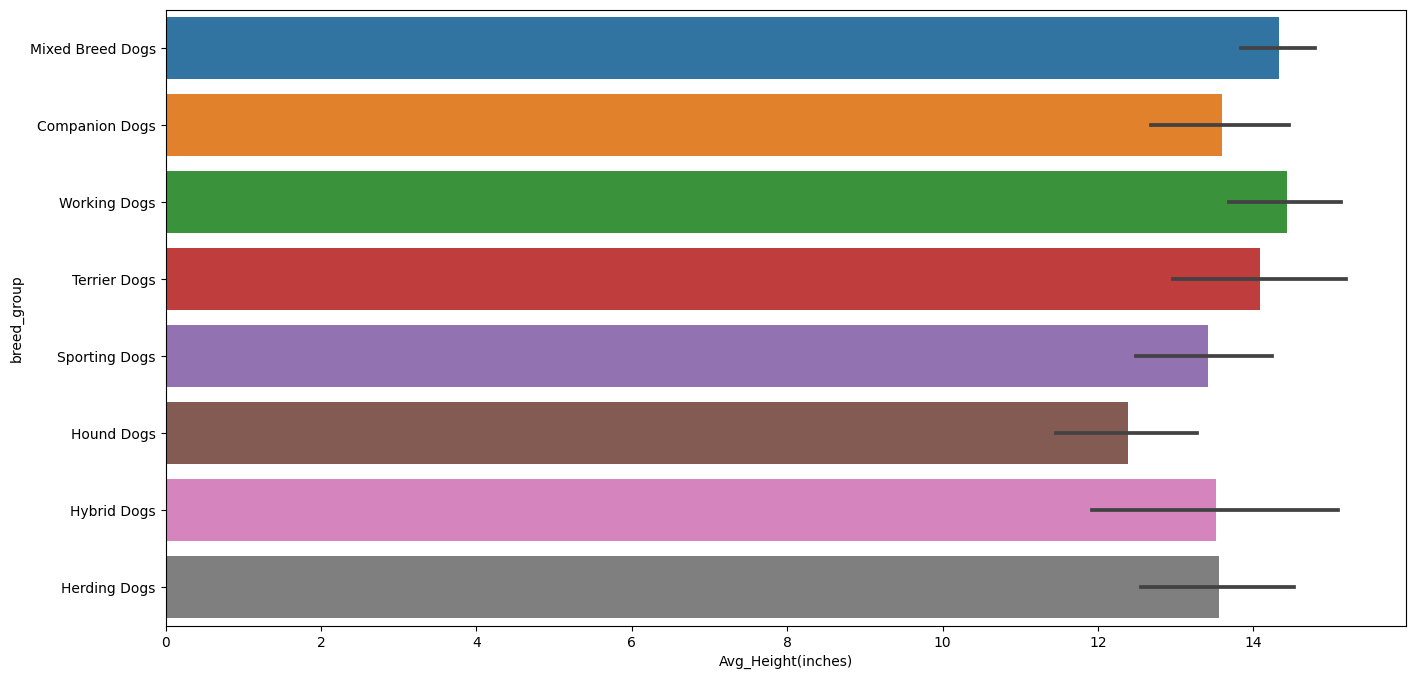

In [18]:
plt.figure(figsize=(16,8))
sns.barplot(train,x='Avg_Height(inches)',y='breed_group')

<Axes: xlabel='Avg_Weight(Pounds)', ylabel='breed_group'>

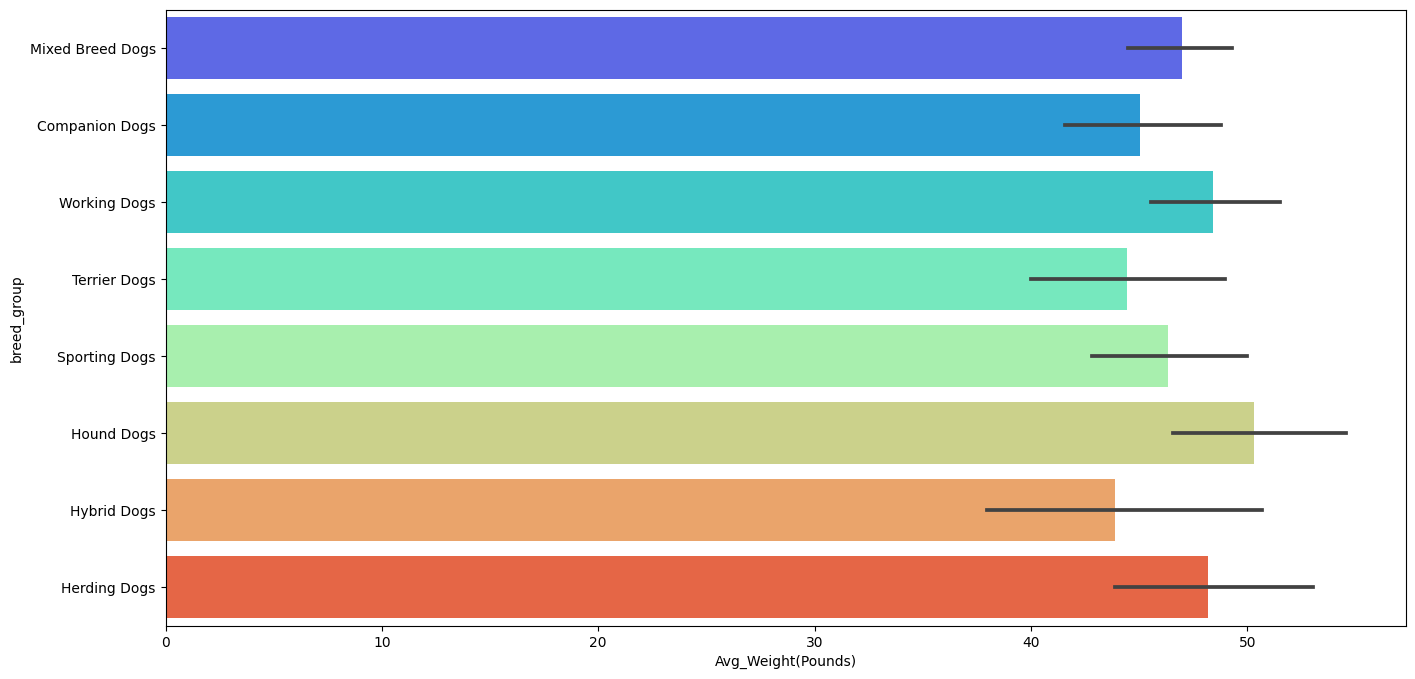

In [19]:
plt.figure(figsize=(16,8))
sns.barplot(train,x='Avg_Weight(Pounds)',y='breed_group',palette='rainbow')

<Axes: xlabel='Avg_Lifespan(Years)', ylabel='breed_group'>

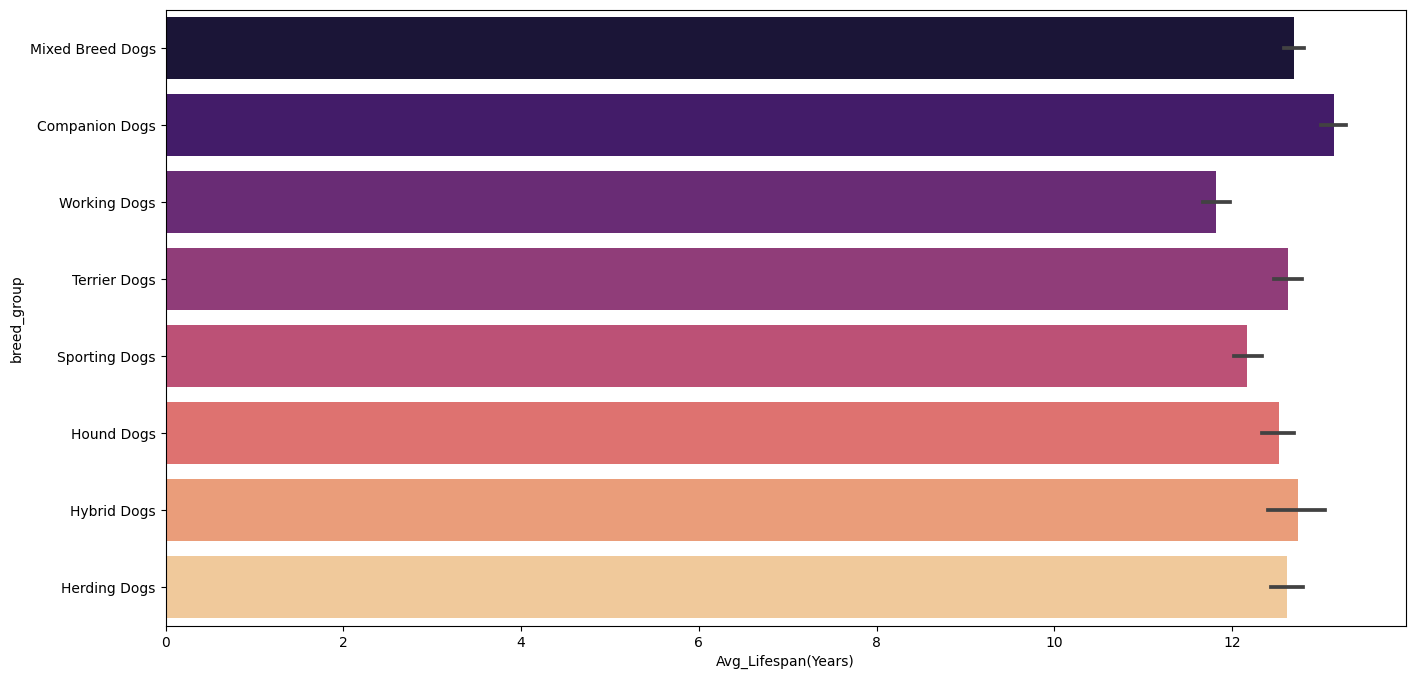

In [20]:
plt.figure(figsize=(16,8))
sns.barplot(train,x='Avg_Lifespan(Years)',y='breed_group',palette='magma')

<Axes: xlabel='Avg_Height(inches)', ylabel='adapts_well_to_apartment_living'>

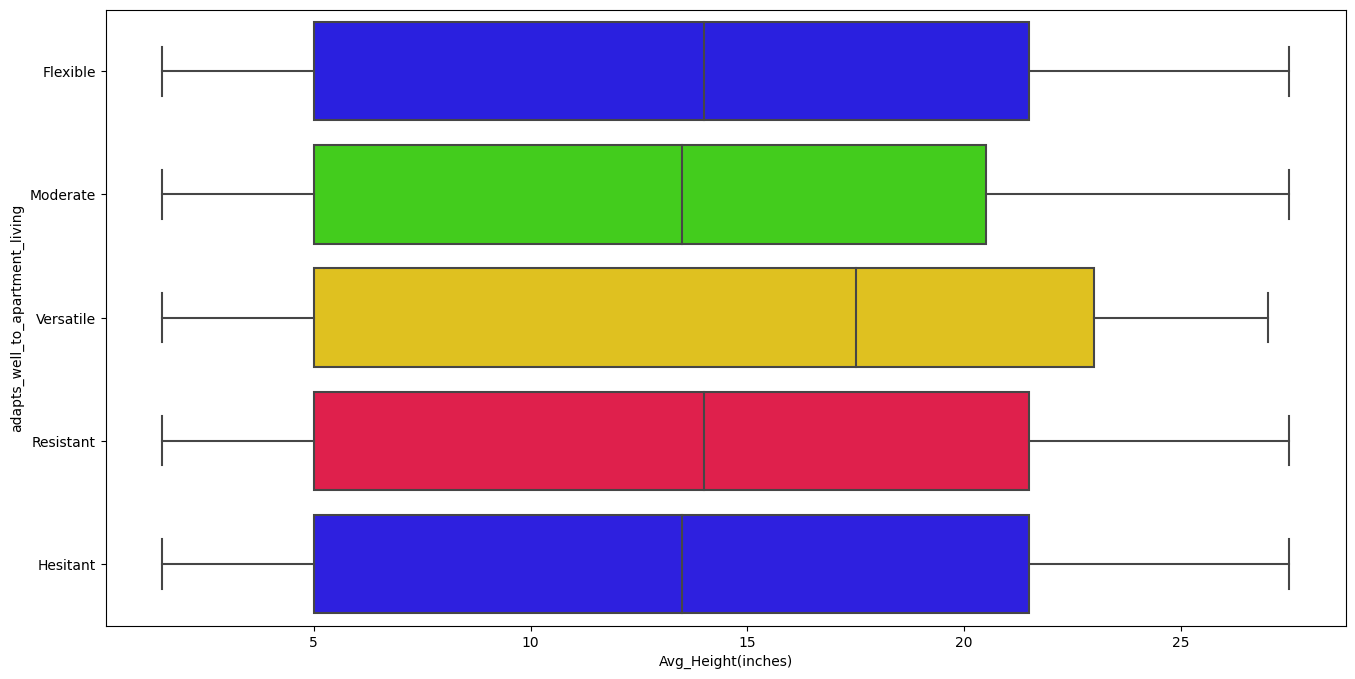

In [21]:
plt.figure(figsize=(16,8))
sns.boxplot(train,x='Avg_Height(inches)',y='adapts_well_to_apartment_living',palette='prism')

<Axes: xlabel='Avg_Weight(Pounds)', ylabel='adapts_well_to_apartment_living'>

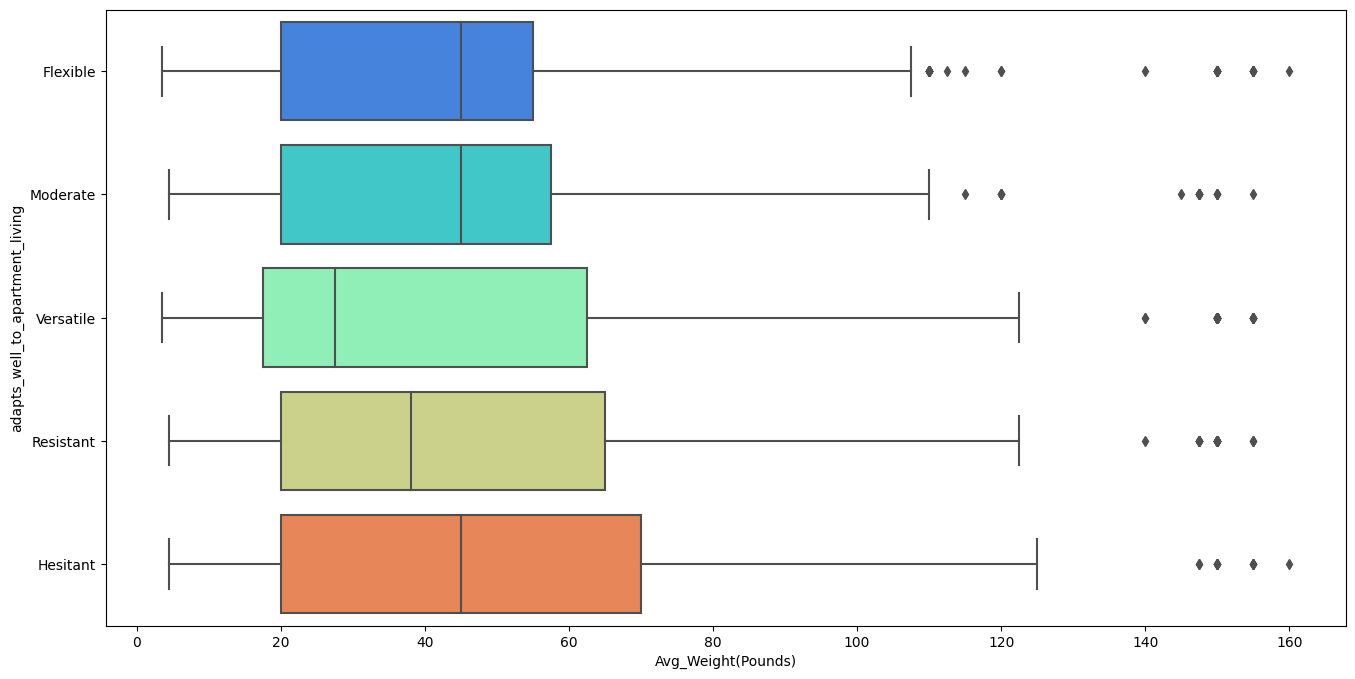

In [22]:
plt.figure(figsize=(16,8))
sns.boxplot(train,x='Avg_Weight(Pounds)',y='adapts_well_to_apartment_living',palette='rainbow')

<Axes: xlabel='Avg_Lifespan(Years)', ylabel='adapts_well_to_apartment_living'>

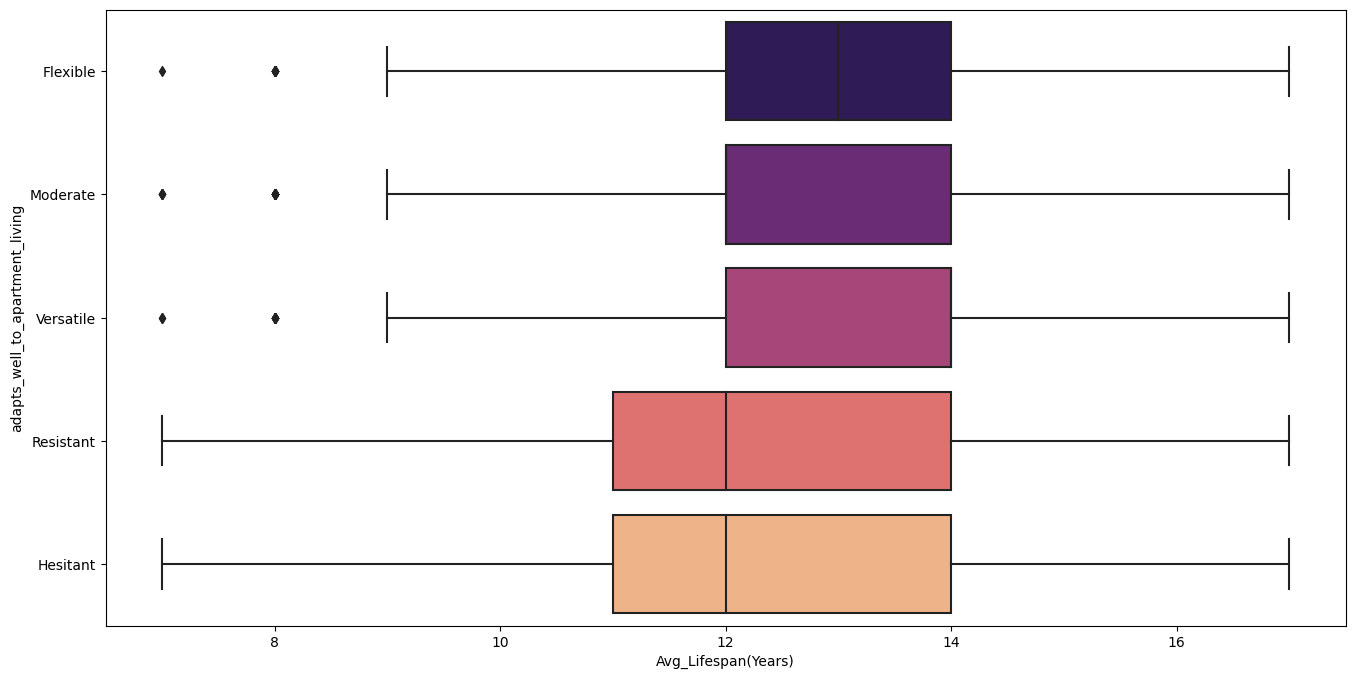

In [23]:
plt.figure(figsize=(16,8))
sns.boxplot(train,x='Avg_Lifespan(Years)',y='adapts_well_to_apartment_living',palette='magma')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Avg_Height(inches)', ylabel='Count'>

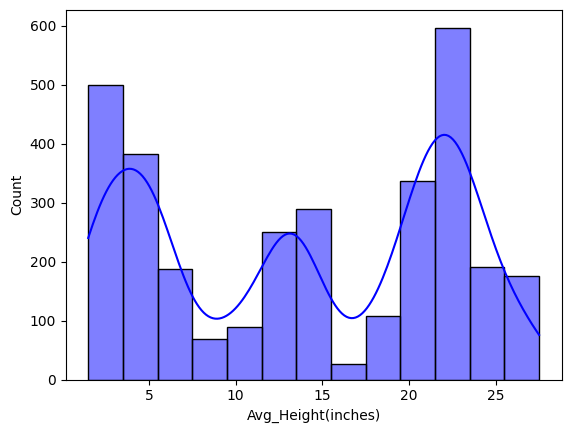

In [24]:
sns.histplot(train,x='Avg_Height(inches)',color='blue',kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Avg_Weight(Pounds)', ylabel='Count'>

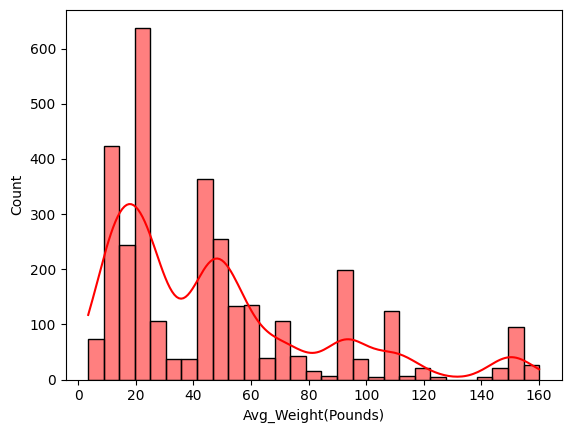

In [25]:
sns.histplot(train,x='Avg_Weight(Pounds)',color='red',kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Avg_Lifespan(Years)', ylabel='Count'>

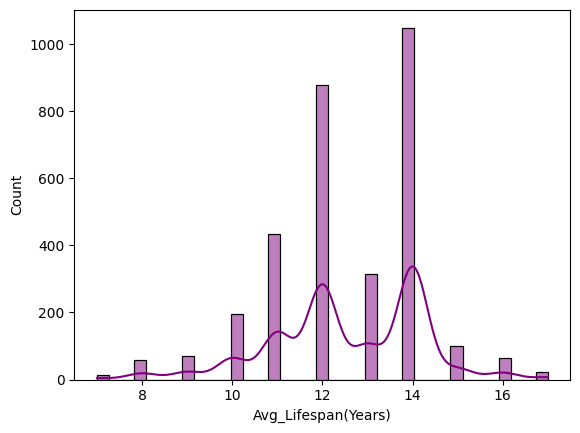

In [26]:
sns.histplot(train,x='Avg_Lifespan(Years)',color='purple',kde=True)

<Axes: xlabel='count', ylabel='breed_group'>

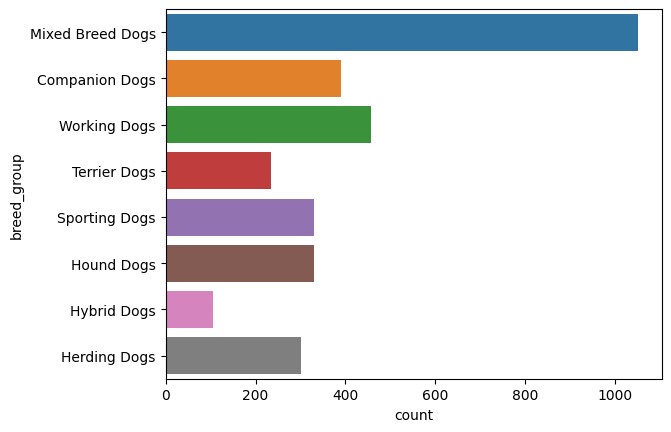

In [27]:
sns.countplot(train,y='breed_group')

<Axes: xlabel='count', ylabel='adapts_well_to_apartment_living'>

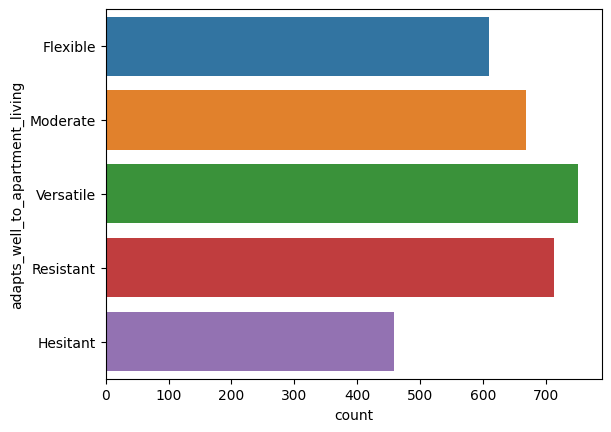

In [28]:
sns.countplot(train,y='adapts_well_to_apartment_living')

<Axes: xlabel='adapts_well_to_apartment_living', ylabel='breed_group'>

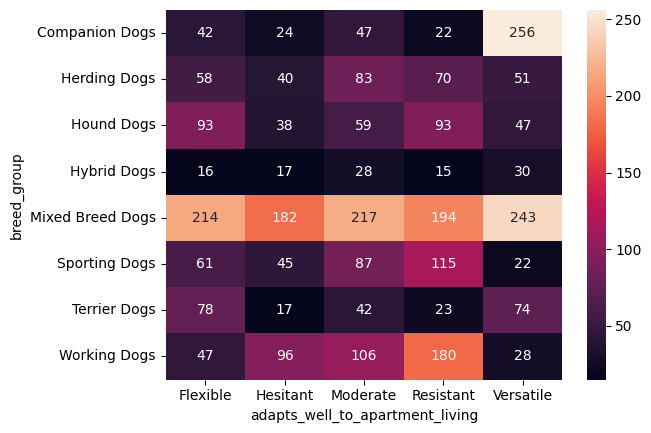

In [29]:
heatmap_data = pd.crosstab(train['breed_group'], train['adapts_well_to_apartment_living'])
sns.heatmap(heatmap_data, annot=True, fmt='d')

In [30]:
cat_cols=input_cols[:-4]
palette = [
    "deep", "muted", "bright", "pastel", "dark", "colorblind", "husl", "Set1", "Set2", "Set3", "tab10", "tab20", "tab20b", "tab20c",
    ["#FF5733", "#33FFB8", "#334BFF"], "ch:s=-.2,r=.6",
    "deep", "muted", "bright", "pastel", "dark", "colorblind", "husl", "Set1", "Set2", "Set3","rainbow","magma","inferno"
]
len(palette)

29

<Figure size 1600x1000 with 0 Axes>

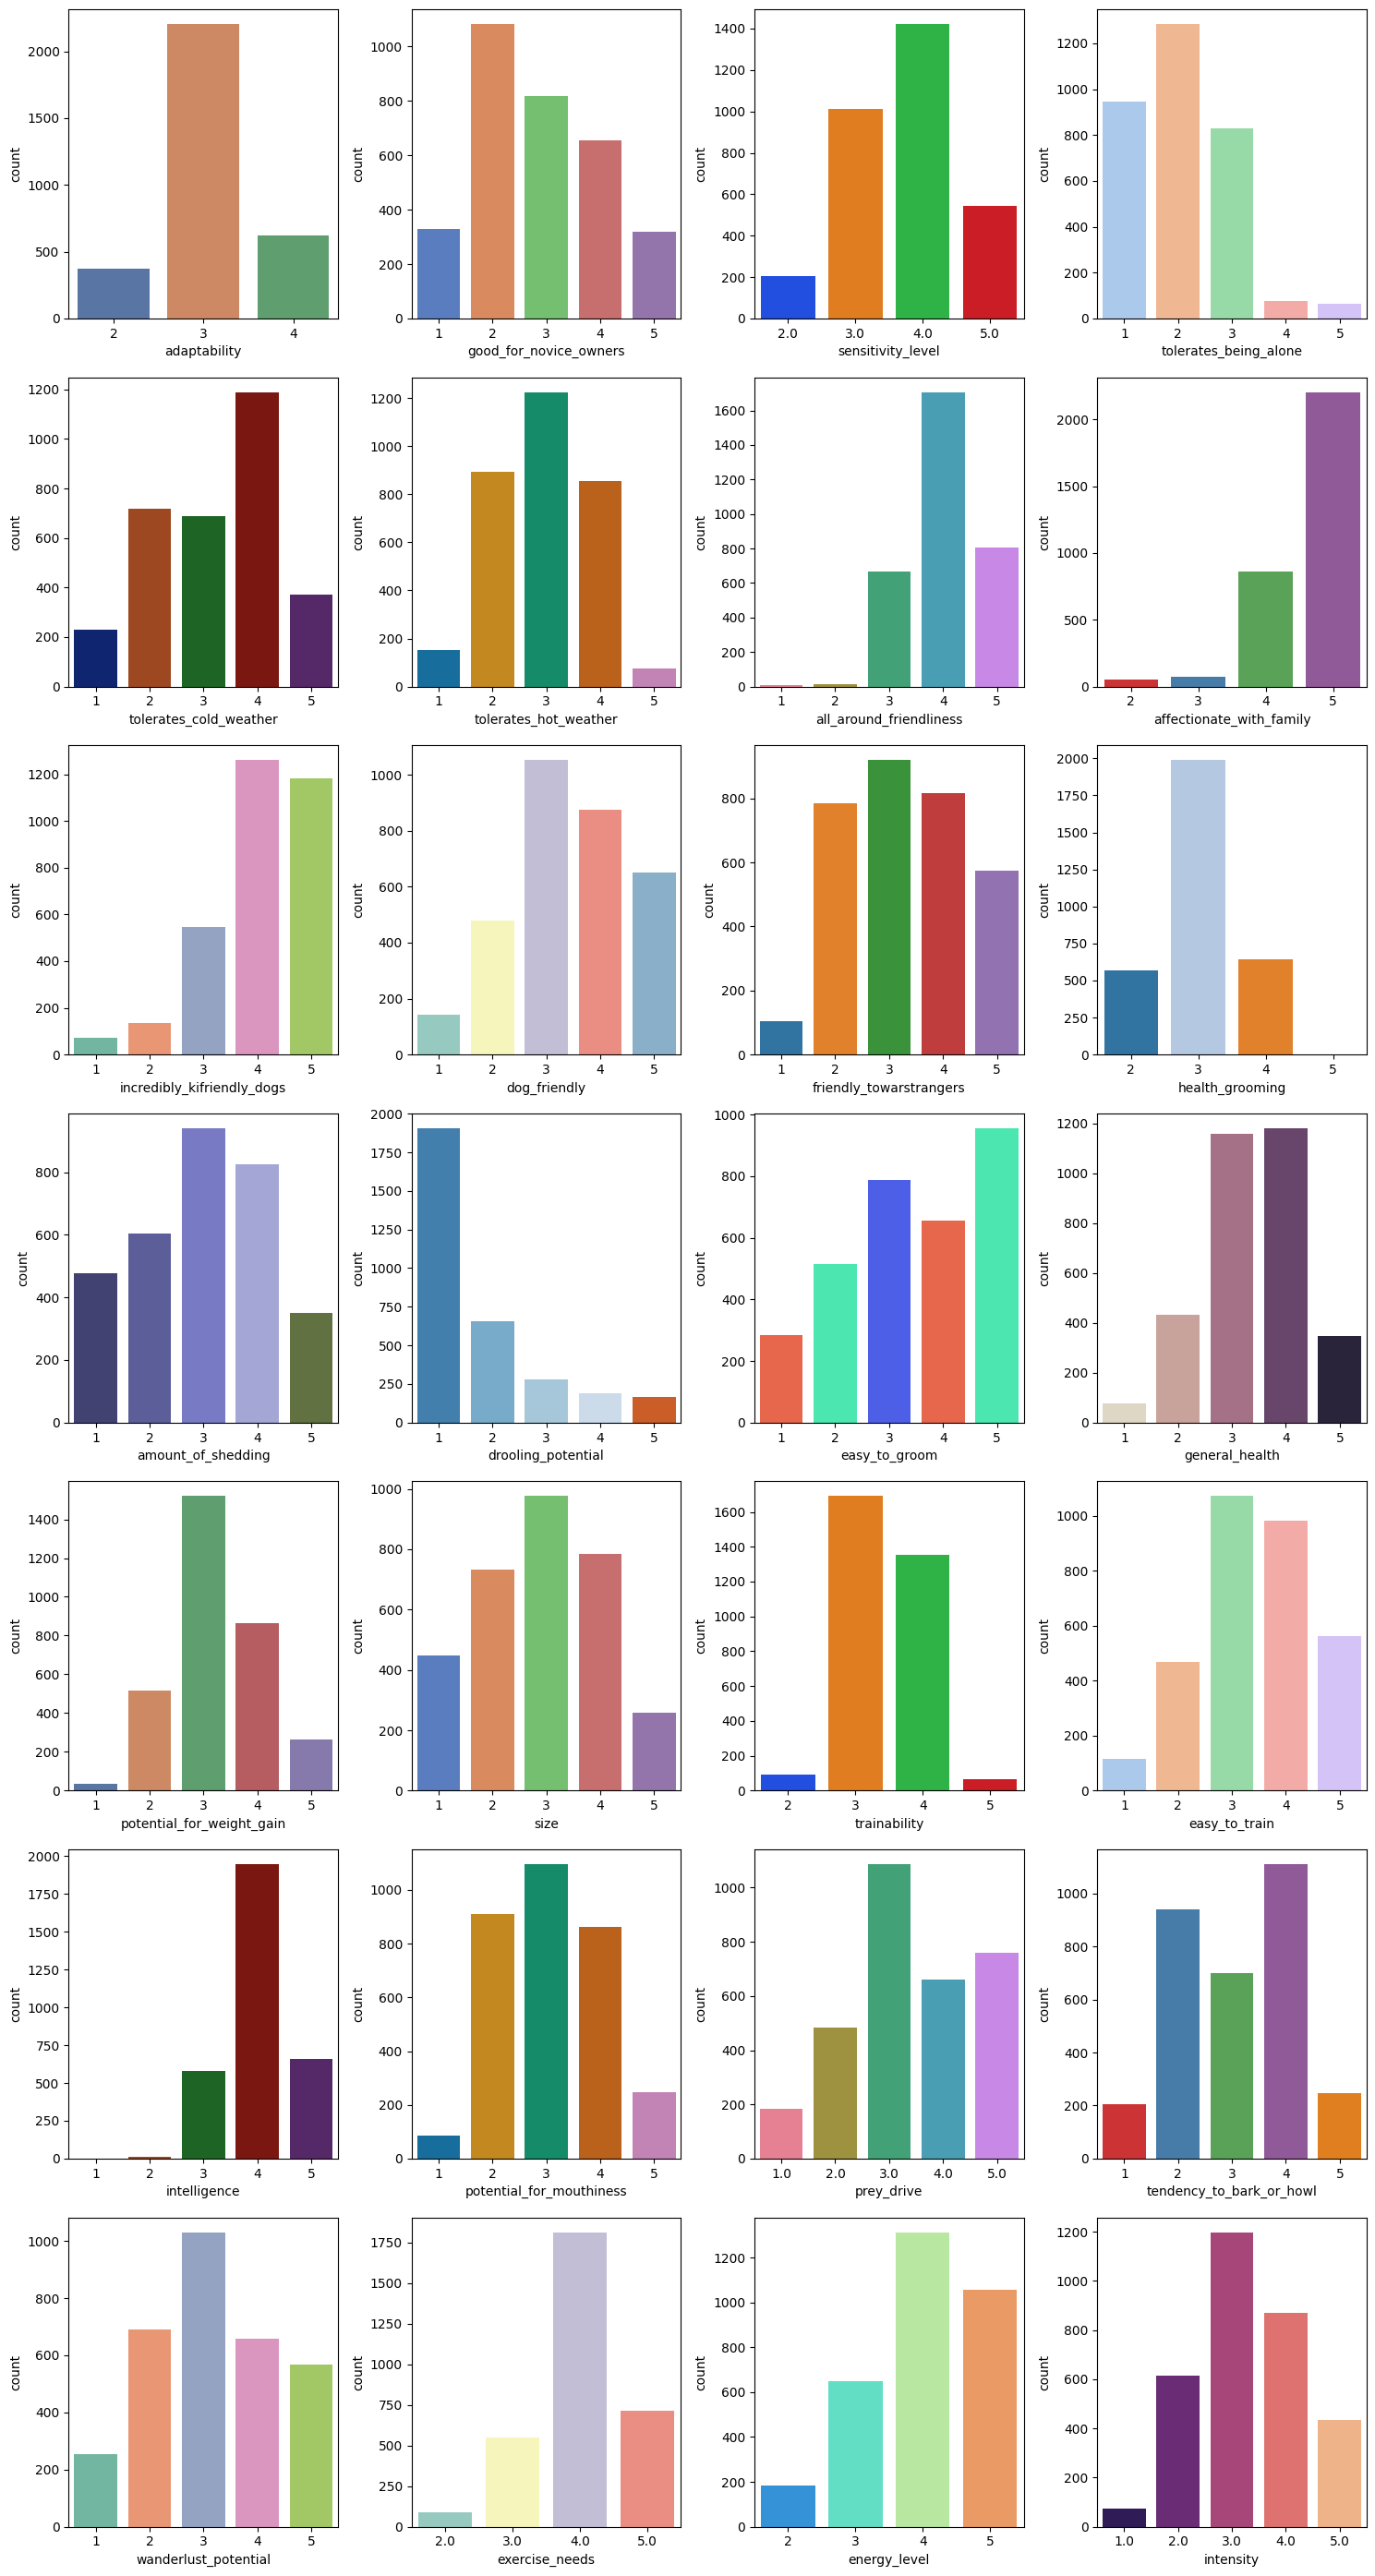

In [31]:
plt.figure(figsize=(16, 10))
def plot_countplots(data):
    num_cols = 4
    num_rows = (len(cat_cols) - 2) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))
    for i in range(len(cat_cols)-1):
        ax = axes[i // num_cols, i % num_cols]
        sns.countplot(data=data, x=cat_cols[i], palette=palette[i], ax=ax,order=data[cat_cols[i]].value_counts().sort_index().index)
    plt.tight_layout()
    
    plt.show()
plot_countplots(train)

<Figure size 1600x1200 with 0 Axes>

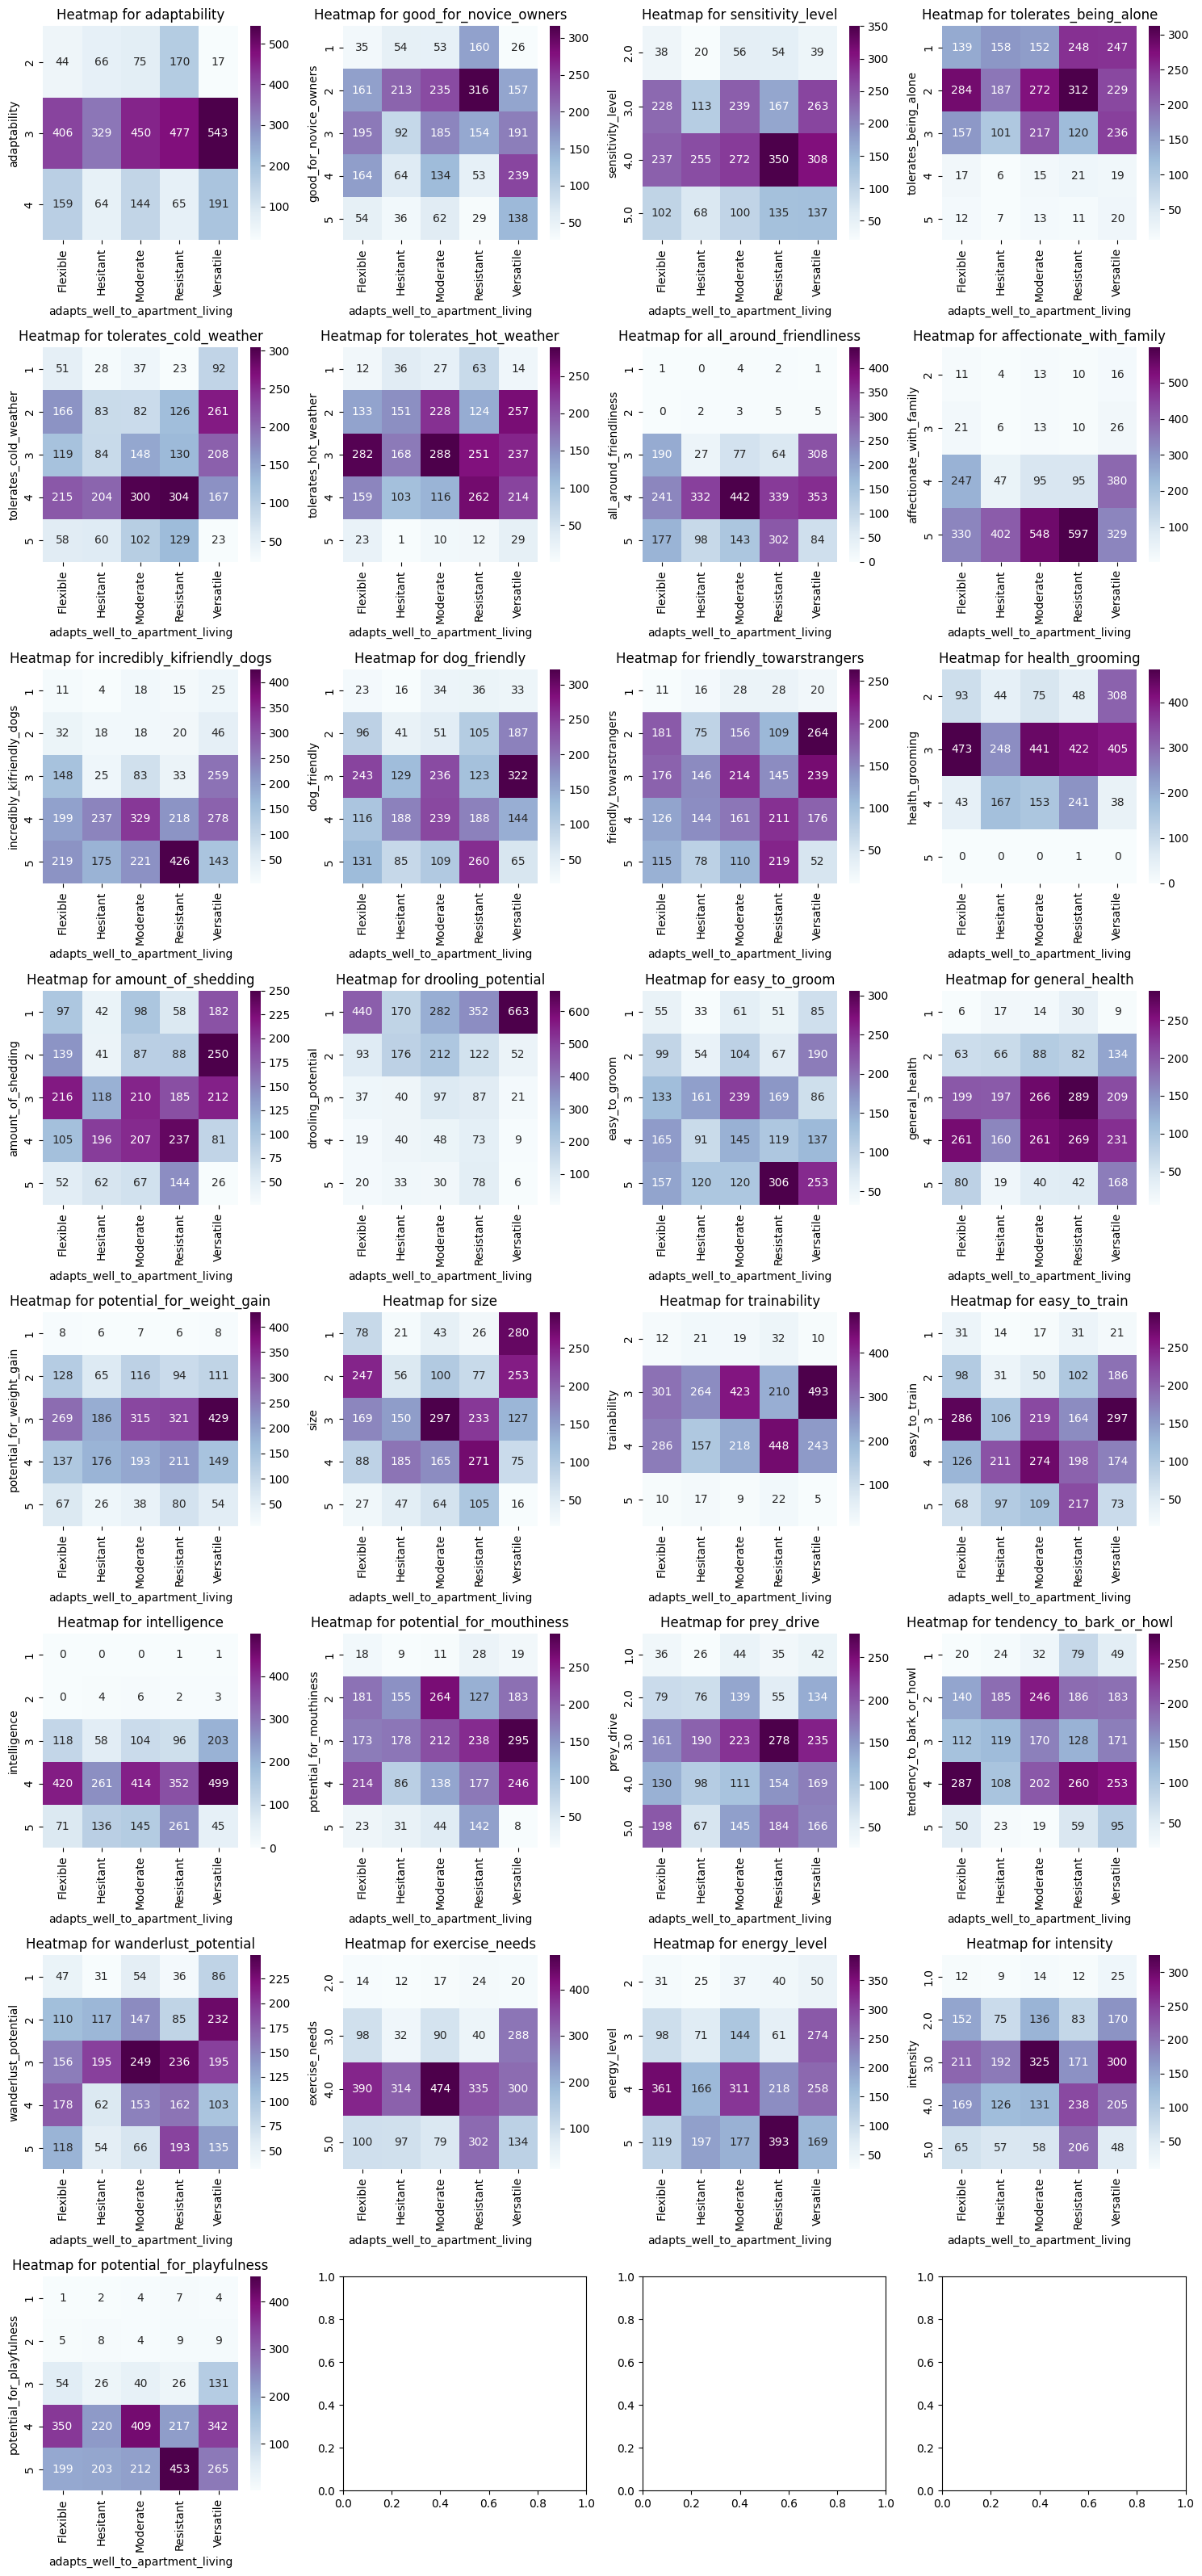

In [32]:
def heatmaps(cols):
    plt.figure(figsize=(16,12))
    num_cols = 4
    num_rows = (len(cols) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))
    i=0
    for col in (cols):
        ax = axes[i // num_cols, i % num_cols]
        heatmap_data = pd.crosstab(train[col], train['adapts_well_to_apartment_living'])
        sns.heatmap(heatmap_data, cmap="BuPu", annot=True, fmt='d', ax=ax)
        ax.set_title(f'Heatmap for {col}')
        i=i+1
    plt.tight_layout()
    plt.show()

heatmaps(cat_cols)

<Axes: >

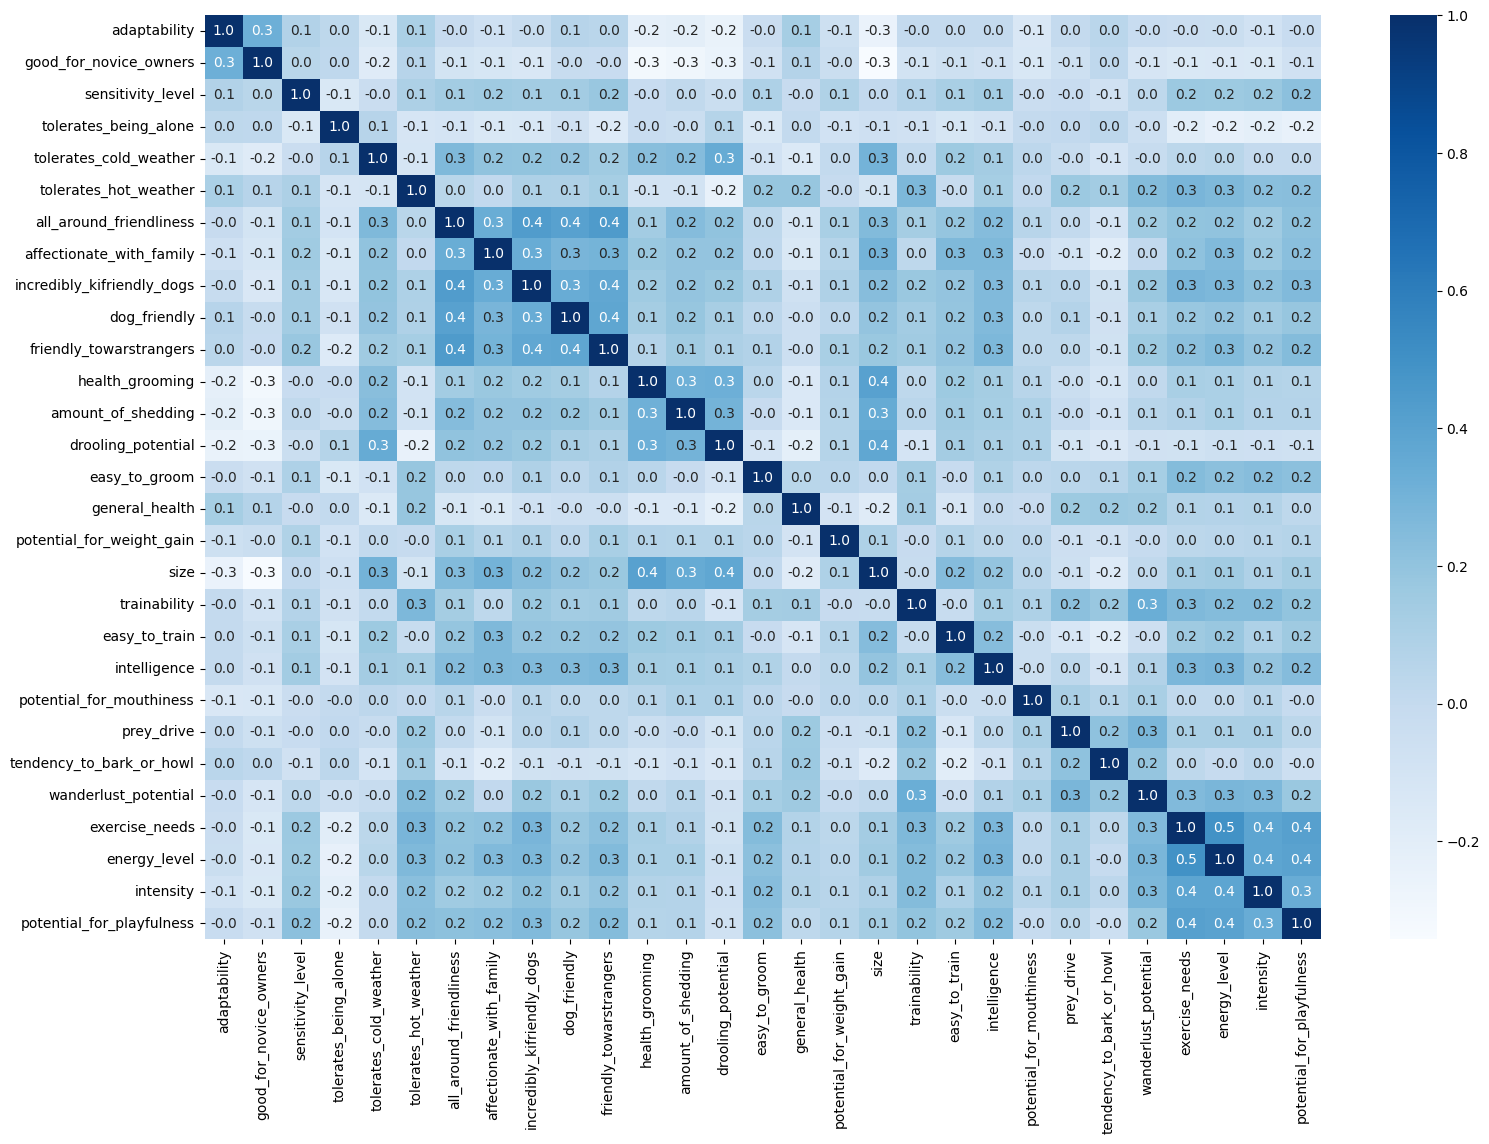

In [33]:
plt.figure(figsize=(18,12))
sns.heatmap(train[cat_cols].corr(),fmt=".1f",cmap="Blues",annot=True)

# Insights
* Avg heights of Working Dogs & Mixed Breed Dogs are higher comparatively
* Avg Weight sof hound dogs are the highest, followed by working and herding dog breeds
* Avg Lifespan of Companion Dogs are the highest, with min lifespan 11 for all breeds
* Most of the dogs fall under Mixed Breed Group in the dataset(33%), with Hybrid Breed quite a few in no.
* If Companion Dog, high probability of it being Versatile
* If Working/Sporting dog, 35-40% chance that it is Resistant
* Other breeds are hard to predict just on the basis of their breeds
* Exercise Needs and Energy levels have strong correlations

* Adaptability: Most Dogs have adaptability level as 3 and dogs mainly under resistant but all levels have almost equal proportions
* Good_for_novice: Majority fall under level 2 and among those, Resistant are highest in number followed by Moderate. Levels 2 and 3 also have a significant majority
* Sensitivity level: Level 4 dominates with category resistant and versatile. Level 3 also has a signficant majority
* Tolerates_being_alone : Level 2 dominates with almost equal distributions in all categories
* Cold_weather : Level 4 dominates, categories Resistant and Moderate
* Hot_weather : Levels 2-4 have significant counts, categories are also not having sigficant win over the other
* Friendliness: Level 4 has the majority and category is mainly Moderate. for level 3 high chances of versatile and for level 5, resistant
* Affection with family: Level 5 dominates with category Moderate/Resistant majorly. If level 4, high chances of being versatile
* Kifriendly dogs: Level 5 has majority under category Resistant
* Potential for playfulness : Level 4 and 5 have mainly all majority, and if Level 5, high chances of it being Resistant
* Health grooming : Level 3 has majority count. If level 2, Versatile probability is more
* Amount of Shedding: Level 1 or 2, Versatile probably.
* Drooling potential: Mainly all dogs have drooling potential 1, and they are either under Flexible or Versatile category
* Easy to groom: Level 5, either Versatile of Resistant probably
* Genral Health: Majority dogs have levels 3 or 4
* Weight gain: Most dogs have level 2
* Size: Level 1-Versatile and Level 2, Flexible or Versatile, very high chances
* Trainability: Levels 3 and 4 have the majority
* Easy to train: Level 5 - Resistant probably
* Intelligence and Exercise needs: Level 4 has the majority. If level 3 for exercise, versatile and if level 5, resistant probably
* Mouthiness: Level 5, Resistant
* Prey Drive: Majority dogs fall under level 3
* Energy Level & Intensity: If level 5, probably resistant

# Feature Engineering

**Encoding**

In [34]:
categorical_cols=['breed_group']
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(X[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_val[encoded_cols] = encoder.transform(X_val[categorical_cols])
test[encoded_cols] = encoder.transform(test[categorical_cols])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
X_train.drop(columns=['breed_group'],inplace=True)
X_val.drop(columns=['breed_group'],inplace=True)
test.drop(columns=['breed_group'],inplace=True)
test.drop(columns=['id'],inplace=True)

In [36]:
object_cols=X_train.columns[:-11]
object_cols

Index(['adaptability', 'good_for_novice_owners', 'sensitivity_level',
       'tolerates_being_alone', 'tolerates_cold_weather',
       'tolerates_hot_weather', 'all_around_friendliness',
       'affectionate_with_family', 'incredibly_kifriendly_dogs',
       'dog_friendly', 'friendly_towarstrangers', 'health_grooming',
       'amount_of_shedding', 'drooling_potential', 'easy_to_groom',
       'general_health', 'potential_for_weight_gain', 'size', 'trainability',
       'easy_to_train', 'intelligence', 'potential_for_mouthiness',
       'prey_drive', 'tendency_to_bark_or_howl', 'wanderlust_potential',
       'exercise_needs', 'energy_level', 'intensity',
       'potential_for_playfulness'],
      dtype='object')

In [37]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(X_train[object_cols])
encoded_cols = list(encoder.get_feature_names_out(object_cols))
X_train[encoded_cols] = encoder.transform(X_train[object_cols])
X_val[encoded_cols] = encoder.transform(X_val[object_cols])
test[encoded_cols] = encoder.transform(test[object_cols])
columns=X_train.columns

In [38]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_val=encoder.transform(y_val)

**Imputation**

In [39]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='most_frequent')
X_train[columns]=imputer.fit_transform(X_train[columns])
X_val[columns]=imputer.transform(X_val[columns])
test[columns]=imputer.transform(test[columns])

**Scaling**

In [40]:
from sklearn.preprocessing import MinMaxScaler
num_cols=['Avg_Height(inches)','Avg_Weight(Pounds)','Avg_Lifespan(Years)']
scaler=MinMaxScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_val[num_cols]=scaler.transform(X_val[num_cols])
test[num_cols]=scaler.transform(test[num_cols])
X_train

,adaptability,good_for_novice_owners,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,all_around_friendliness,affectionate_with_family,incredibly_kifriendly_dogs,dog_friendly,...,Avg_Weight(Pounds),Avg_Lifespan(Years),breed_group_Companion Dogs,breed_group_Herding Dogs,breed_group_Hound Dogs,breed_group_Hybrid Dogs,breed_group_Mixed Breed Dogs,breed_group_Sporting Dogs,breed_group_Terrier Dogs,breed_group_Working Dogs
700,2.0,0.0,1.0,1.0,3.0,2.0,3.0,3.0,4.0,3.0,...,0.079872,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1220,1.0,3.0,0.0,2.0,2.0,3.0,3.0,3.0,0.0,2.0,...,0.345048,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3036,1.0,1.0,2.0,0.0,3.0,2.0,3.0,3.0,4.0,4.0,...,0.680511,0.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.0,2.0,2.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,...,0.568690,0.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
533,1.0,3.0,3.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,...,0.137380,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,2.0,3.0,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,...,0.130990,0.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1130,1.0,3.0,2.0,1.0,3.0,3.0,4.0,3.0,4.0,4.0,...,0.408946,0.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1294,2.0,3.0,3.0,0.0,1.0,2.0,3.0,3.0,4.0,3.0,...,0.105431,0.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,1.0,2.0,2.0,0.0,3.0,2.0,4.0,3.0,4.0,4.0,...,0.028754,0.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Some values are very low in number in various categorical columns as you must have observed during the EDA, I have replaced them(Also tried without replacing, performance didnt improve but deteriorated in a few cases)

In [41]:
X_train['all_around_friendliness'].replace({1:3,0:4},inplace=True)
X_train['tolerates_being_alone'].replace({3:1,4:0},inplace=True)
X_train['potential_for_weight_gain'].replace({0:2},inplace=True)
X_train['intensity'].replace({0:2},inplace=True)
X_train['incredibly_kifriendly_dogs'].replace({0:3,1:4},inplace=True)
X_train['trainability'].replace({0:1,3:2},inplace=True)
X_train['exercise_needs'].replace({0:2},inplace=True)
X_train['potential_for_mouthiness'].replace({0:2},inplace=True)
X_train['intelligence'].replace({0:3,1:4},inplace=True)
X_train['easy_to_train'].replace({0:2},inplace=True)
X_train['general_health'].replace({0:3},inplace=True)
X_train['health_grooming'].replace({3:1},inplace=True)
X_train['friendly_towarstrangers'].replace({0:2},inplace=True)

/tmp/ipykernel_18/1855200627.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['all_around_friendliness'].replace({1:3,0:4},inplace=True)
/tmp/ipykernel_18/1855200627.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [42]:
from sklearn.preprocessing import PowerTransformer
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
X_train[num_cols] = yeo_johnson_transformer.fit_transform(X_train[num_cols])
X_val[num_cols] = yeo_johnson_transformer.transform(X_val[num_cols])
test[num_cols]=yeo_johnson_transformer.transform(test[num_cols])

Note: I even tried introducing some new features but model performance deteriorated for me. Also, in the below modelling process, most of the hyperparameters have been used after performing GridSearchCV but are not shown due to execution time everytime I edit the model

# Modelling

**Xgboost**

In [43]:
import xgboost as xgb
#After GridSearchCV
model = xgb.XGBClassifier(
    random_state=42,n_jobs=-1,
    learning_rate=0.001,
    max_depth=5,
    n_estimators=200,
    subsample=0.2,
    colsample_bytree=0.5,
    gamma=1
)

In [44]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [45]:
val_pred=model.predict(X_val)
from sklearn.metrics import accuracy_score
accuracy_score(val_pred,y_val)

0.465625

**Decision Tree Classifier**

In [46]:
from sklearn.tree import DecisionTreeClassifier
model2=DecisionTreeClassifier(max_depth=5,random_state=42,ccp_alpha=0,min_samples_split=6,splitter='best',min_samples_leaf=1,max_features=None)
model2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_split=6,
                       random_state=42)

In [47]:
val_pred2=model2.predict(X_val)
accuracy_score(val_pred2,y_val)

0.4421875

**Logistic Regression**

In [48]:
from sklearn.linear_model import LogisticRegression
model_lr=LogisticRegression(n_jobs=-1,random_state=42,multi_class='multinomial',max_iter=1000)
from sklearn.model_selection import StratifiedKFold,GridSearchCV
param_grid={
    'penalty':['l1','l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
grid_search=GridSearchCV(estimator=model_lr,param_grid=param_grid,cv=cv,scoring='accuracy')
grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/l

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial', n_jobs=-1,
                                          random_state=42),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='accuracy')

In [49]:
grid_search.best_params_

{'penalty': 'l1', 'solver': 'saga'}

In [50]:
model_lr=LogisticRegression(n_jobs=-1,random_state=42,multi_class='multinomial',max_iter=1000,penalty='l1',solver='saga')
model_lr.fit(X_train,y_train)
val_pred_lr=model_lr.predict(X_val)
accuracy_score(val_pred_lr,y_val)

0.434375

**Support Vector Machines**

In [51]:
from sklearn.svm import SVC
#After GridSearchCV
model_svc=SVC(random_state=42,C=1,kernel='rbf',degree=2)
model_svc.fit(X_train,y_train)

SVC(C=1, degree=2, random_state=42)

In [52]:
val_pred_svc=model_svc.predict(X_val)
accuracy_score(val_pred_svc,y_val)

0.4640625

**Gradient Boosting**

In [53]:
model_gb = GradientBoostingClassifier(random_state=42,max_depth=3,criterion='friedman_mse',subsample=0.4,n_estimators=100,learning_rate=0.01,loss='log_loss',min_samples_split=6)

In [54]:
model_gb.fit(X_train,y_train)
val_pred=model_gb.predict(X_val)
from sklearn.metrics import accuracy_score
accuracy_score(val_pred,y_val)

0.4671875

In [55]:
X_train_copy=X_train.copy()
X_val_copy=X_val.copy()
feature_imp=model_gb.feature_importances_
df=pd.DataFrame({'cols':X_train.columns,'imp':feature_imp})
df = df.sort_values(by='imp', ascending=False)
imp_df=df.head(10)
imp_cols=imp_df['cols']
X_train_copy=X_train_copy[imp_cols]
X_val_copy=X_val_copy[imp_cols]
model_gb_copy= GradientBoostingClassifier(random_state=42,max_depth=5,criterion='squared_error',subsample=0.4,n_estimators=100,learning_rate=0.01,loss='log_loss',min_samples_split=6)
model_gb_copy.fit(X_train_copy,y_train)

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.01,
                           max_depth=5, min_samples_split=6, random_state=42,
                           subsample=0.4)

In [56]:
val_pred_copy=model_gb_copy.predict(X_val_copy)
from sklearn.metrics import accuracy_score
accuracy_score(val_pred_copy,y_val)

0.4625

Doing this, performace didnt improve, tried for all models

**Catboost**

In [57]:
model_cb=CatBoostClassifier(random_state=29,auto_class_weights='None',depth=10,iterations=200,leaf_estimation_iterations=10,loss_function='MultiClass',learning_rate=0.01,
                           border_count=10,l2_leaf_reg=0.1,)
model_cb.fit(X_train,y_train)
val_pred_cb=model_cb.predict(X_val)
accuracy_score(val_pred_cb,y_val)

0:	learn: 1.5921093	total: 83.1ms	remaining: 16.5s
1:	learn: 1.5887342	total: 92.3ms	remaining: 9.14s
2:	learn: 1.5703420	total: 119ms	remaining: 7.79s
3:	learn: 1.5520047	total: 144ms	remaining: 7.08s
4:	learn: 1.5328705	total: 169ms	remaining: 6.6s
5:	learn: 1.5140698	total: 194ms	remaining: 6.26s
6:	learn: 1.4989298	total: 219ms	remaining: 6.04s
7:	learn: 1.4834857	total: 245ms	remaining: 5.87s
8:	learn: 1.4698275	total: 270ms	remaining: 5.72s
9:	learn: 1.4562379	total: 297ms	remaining: 5.64s
10:	learn: 1.4405825	total: 324ms	remaining: 5.57s
11:	learn: 1.4230595	total: 349ms	remaining: 5.47s
12:	learn: 1.4064470	total: 374ms	remaining: 5.38s
13:	learn: 1.3911532	total: 399ms	remaining: 5.3s
14:	learn: 1.3783113	total: 424ms	remaining: 5.23s
15:	learn: 1.3660675	total: 450ms	remaining: 5.17s
16:	learn: 1.3497689	total: 476ms	remaining: 5.12s
17:	learn: 1.3316960	total: 504ms	remaining: 5.09s
18:	learn: 1.3149831	total: 530ms	remaining: 5.05s
19:	learn: 1.2973628	total: 555ms	remaini

0.48125

# Stacking

In [58]:
estimators = [
    ('xgb', xgb.XGBClassifier(
    random_state=42,n_jobs=-1,
    learning_rate=0.001,
    max_depth=5,
    n_estimators=200,
    subsample=0.2,
    colsample_bytree=0.5,
    gamma=1
)),
    ('model_svc', SVC(random_state=42,C=1,kernel='rbf',degree=2)),
    ('adaboost', AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.1,n_estimators=400)),
    ('rf',RandomForestClassifier(criterion='gini',max_depth=7,max_features=10,n_estimators=400)),
    ('gb',GradientBoostingClassifier(random_state=42,max_depth=3,criterion='friedman_mse',subsample=0.4,n_estimators=100,learning_rate=0.01,loss='log_loss',min_samples_split=6)),
    ('cb',CatBoostClassifier(random_state=29,auto_class_weights='None',depth=10,iterations=200,leaf_estimation_iterations=10,loss_function='MultiClass',learning_rate=0.01,
                           border_count=10,l2_leaf_reg=0.1,))
 ]
clf=StackingClassifier(estimators=estimators,final_estimator=LogisticRegression(n_jobs=-1,random_state=42,multi_class='multinomial',max_iter=1000,penalty='l1',solver='saga'))

In [59]:
clf.fit(X_train,y_train)
val_pred_stack=clf.predict(X_val)
from sklearn.metrics import accuracy_score
accuracy_score(val_pred_stack,y_val)

0:	learn: 1.5921093	total: 25.5ms	remaining: 5.08s
1:	learn: 1.5887342	total: 34.1ms	remaining: 3.38s
2:	learn: 1.5703420	total: 60.4ms	remaining: 3.96s
3:	learn: 1.5520047	total: 84.8ms	remaining: 4.16s
4:	learn: 1.5328705	total: 109ms	remaining: 4.26s
5:	learn: 1.5140698	total: 134ms	remaining: 4.33s
6:	learn: 1.4989298	total: 159ms	remaining: 4.38s
7:	learn: 1.4834857	total: 185ms	remaining: 4.44s
8:	learn: 1.4698275	total: 210ms	remaining: 4.45s
9:	learn: 1.4562379	total: 236ms	remaining: 4.49s
10:	learn: 1.4405825	total: 261ms	remaining: 4.48s
11:	learn: 1.4230595	total: 285ms	remaining: 4.46s
12:	learn: 1.4064470	total: 309ms	remaining: 4.44s
13:	learn: 1.3911532	total: 333ms	remaining: 4.43s
14:	learn: 1.3783113	total: 358ms	remaining: 4.41s
15:	learn: 1.3660675	total: 382ms	remaining: 4.39s
16:	learn: 1.3497689	total: 407ms	remaining: 4.38s
17:	learn: 1.3316960	total: 431ms	remaining: 4.35s
18:	learn: 1.3149831	total: 456ms	remaining: 4.35s
19:	learn: 1.2973628	total: 483ms	rem

0.4828125

This was the best Stacking accuracy I could get after many experiments

# Neural Networks

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.22187499701976776

Best val_accuracy So Far: 0.43281251192092896
Total elapsed time: 00h 00m 29s
Epoch 6/100


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4445 - loss: 1.3271 - val_accuracy: 0.4219 - val_loss: 1.3440
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4451 - loss: 1.2940 - val_accuracy: 0.4297 - val_loss: 1.3404
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4195 - loss: 1.3343 - val_accuracy: 0.4328 - val_loss: 1.3347
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4419 - loss: 1.3071 - val_accuracy: 0.4297 - val_loss: 1.3348
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4584 - loss: 1.2891 - val_accuracy: 0.4359 - val_loss: 1.3335
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4596 - loss: 1.2950 - val_accuracy: 0.4328 - val_loss: 1.3341
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4457 - loss: 1.2979 - val_accuracy: 0.4313 - val_loss: 1.3403
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4624 - loss: 1.2815 - val_accuracy: 0.4344 - val_loss:

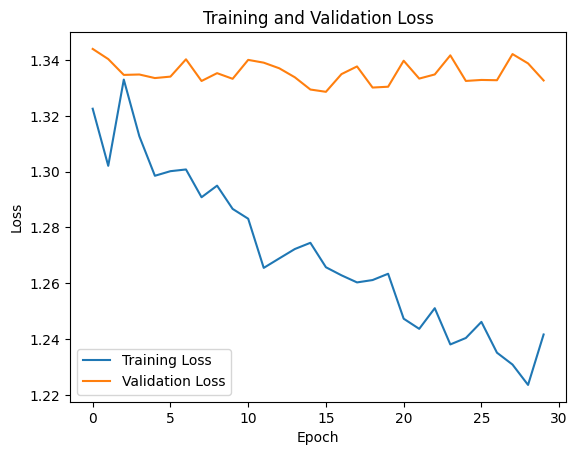

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.4328125

In [60]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=15,
    restore_best_weights=True,
)
tf.random.set_seed(42)

def build_model(hp):
    model = Sequential()
    c = 0
    for i in range(hp.Int('num_layers', min_value=1, max_value=12)):
        if c == 0:
            model.add(Dense(hp.Int('units'+str(i), min_value=24, max_value=256,step=8),
                            activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid']),
                            input_dim=40))
            model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4])))
            c = 1
        else:
            model.add(Dense(hp.Int('units'+str(i), min_value=8, max_value=132,step=4),
                            activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid'])))
            model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4])))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=hp.Choice('optimizer', values=['rmsprop', 'Adam', 'SGD', 'momentum', 'nadam', 'adadelta']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=5,
                        directory='adapts_to_apartment_living',
                        project_name='tuner_31')

tuner.search(X_train, y_train, epochs=5,batch_size=8,validation_data=(X_val, y_val))

tuner.get_best_hyperparameters()[0].values

model_ann=tuner.get_best_models(num_models=1)[0]

history=model_ann.fit(X_train,y_train,validation_data=(X_val,y_val),initial_epoch=5,epochs=100,callbacks=early_stopping)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

pred=model_ann.predict(X_val)
y_pred = np.argmax(pred, axis=1)
y_pred

accuracy_score(y_pred,y_val)

Dataset is too small for ANN to work efficiently, as I expected. Other ML algorithms have performed better, tried tuning multiple times

# Conclusion

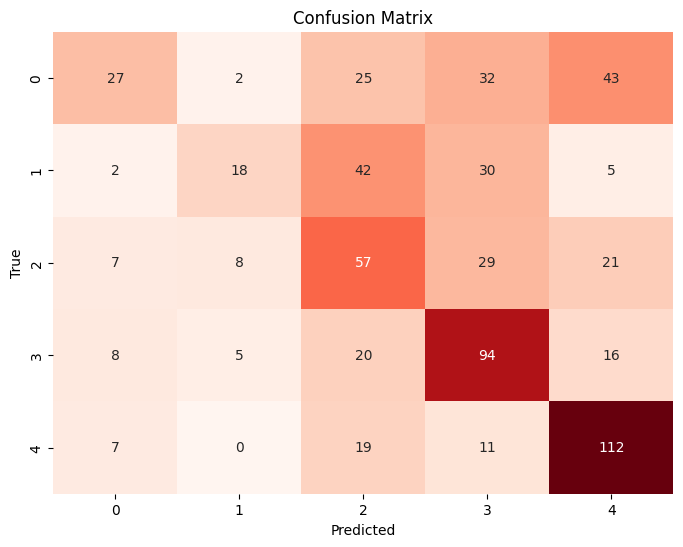

In [61]:
from sklearn.metrics import confusion_matrix,classification_report
cf = confusion_matrix(y_val, val_pred_cb)
plt.figure(figsize=(8, 6))
sns.heatmap(cf, annot=True, fmt='g', cmap='Reds', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
print(classification_report(y_val, val_pred_cb))

              precision    recall  f1-score   support

           0       0.53      0.21      0.30       129
           1       0.55      0.19      0.28        97
           2       0.35      0.47      0.40       122
           3       0.48      0.66      0.55       143
           4       0.57      0.75      0.65       149

    accuracy                           0.48       640
   macro avg       0.49      0.45      0.44       640
weighted avg       0.50      0.48      0.45       640



In [63]:
y_train_encoded=y_train
y_train_actual=encoder.inverse_transform(y_train)
df=pd.DataFrame({'encoded':y_train_encoded,'actual':y_train_actual})
df.sample(20)

,encoded,actual
2365,2,Moderate
9,2,Moderate
2136,3,Resistant
2142,3,Resistant
1239,0,Flexible
809,3,Resistant
351,4,Versatile
1750,0,Flexible
90,0,Flexible
934,0,Flexible


In [64]:
pred_cb=model_cb.predict(test)
sample_submission['adapts_well_to_apartment_living']=encoder.inverse_transform(pred_cb)
sample_submission.to_csv('catboost.csv',index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As during EDA, Resistant and Versatile could still be predicted to a larger extent but other categories were not vividly probable, confusion_matrix shows similar results. A larger dataset would perhaps work better

I tried a lot of other techniques but couldn't get past the accuracy of even 50% with this dataset. If the notebook helps, please upvote. Also, put forwards your suggestion as to what other things I can try to improve the model's performance and what other improvements can be done. Thankyou!